In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

from preprocess import label_to_id
from preprocess import Vocabulary
from model import RNN

In [2]:
# 构建词汇表并保存
vocab = Vocabulary()
with open("./data.txt", 'r') as f:
    for line in f.readlines():
        vocab.add_text(line.split('\t')[1])
vocab.build_vocab()
vocab.save_vocabulary()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yuyun\AppData\Local\Temp\jieba.cache
Loading model cost 0.717 seconds.
Prefix dict has been built successfully.


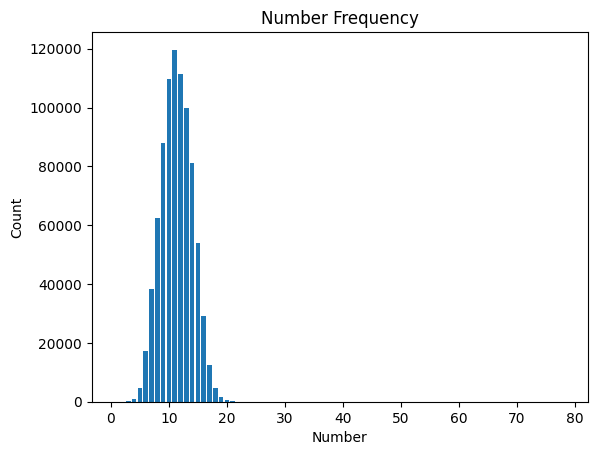

In [3]:
# 可视化新闻标题进行分词后的长度
counts = Counter(vocab.len_of_text)
x = counts.keys()
y = counts.values()

plt.bar(x, y)
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Number Frequency')
plt.show()

In [4]:
# 超参数设置
vocab_size = vocab.num_words
embedding_dim = 64
hidden_dim = 128
output_dim = 14
n_layers = 2
dropout = 0.5
max_len = 20
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 10

In [5]:
# 数据预处理
def text_to_id(data_path, max_len):
    class_name = label_to_id()
    label = []
    content = []
    with open(data_path, 'r') as f:
        temp_content = []
        for line in f.readlines():
            line = line.split('\t')
            label.append(class_name.get(line[0]))
            temp_content = vocab.text_to_ids(line[1])
            lenx = len(temp_content)
            if lenx < max_len: temp_content += [0 for _ in range(max_len - lenx)]
            else: temp_content = temp_content[0:max_len]
            content.append(temp_content)
    return torch.tensor(content), torch.tensor(label)

x_train, y_train = text_to_id("./train.txt", max_len = max_len)
x_test, y_test = text_to_id("./test.txt", max_len = max_len)
x_val, y_val = text_to_id("./val.txt", max_len = max_len)

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# 初始化model和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim = hidden_dim,output_dim=output_dim, n_layers= n_layers, dropout=dropout)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()

In [7]:
# 训练模型
import json


training_log={}
epoch_loss=[]
step_loss=[]
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    print()
    step=0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step+=1
        print(f'\repoch{epoch+1} step{step}/{len(train_loader)} loss:{loss.item():.4f} ',end='')
        step_loss.append(loss.item())
    epoch_loss.append(loss.item())
    save_path=f'./res_model/model_epoch{epoch+1}.pth'
    torch.save(model,save_path)

training_log["epoch_num"]=EPOCHS
training_log["loss_epoch"]=epoch_loss
training_log["loss_step"]=step_loss

with open('training_log.json', 'w') as f:
    json.dump(training_log, f)
    


epoch1 step5291/5291 loss:0.7561 
epoch2 step5291/5291 loss:0.4092 
epoch3 step5291/5291 loss:0.5228 
epoch4 step5291/5291 loss:0.3519 
epoch5 step5291/5291 loss:0.4034 
epoch6 step5291/5291 loss:0.4642 
epoch7 step5291/5291 loss:0.4276 
epoch8 step5291/5291 loss:0.2244 
epoch9 step5291/5291 loss:0.3594 
epoch10 step5291/5291 loss:0.3031 

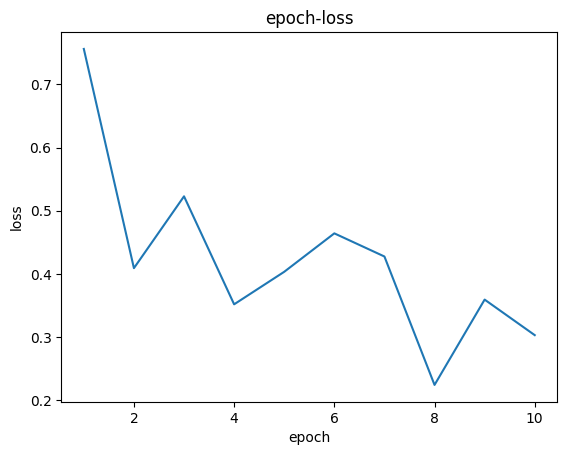

In [8]:
# loss分析
with open('training_log.json') as f:
    data = json.load(f)

epoch_list = list(range(1, data['epoch_num']+1))
epoch_loss = data['loss_epoch']
epoch_step = data['loss_step']

plt.plot(epoch_list, epoch_loss)
plt.title('epoch-loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

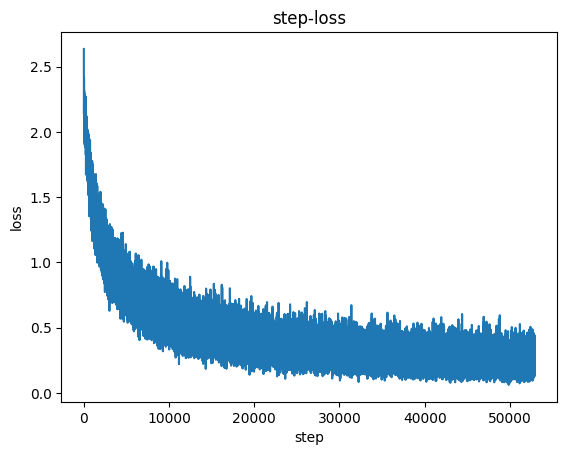

In [9]:
# loss分析
plt.plot(list(range(1,len(epoch_step)+1)), epoch_step)
plt.title('step-loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [10]:
save_path='./res_model/model_epoch8.pth'
torch.save(model,save_path)

In [5]:
load_path='./res_model/model_epoch8.pth'
model=torch.load(load_path)

In [6]:
# 测试模型
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

accuracy = (all_preds.argmax(dim=1) == all_labels).float().mean().item()
print("Accuracy: {:.2f}%".format(accuracy * 100))

NameError: name 'test_loader' is not defined

In [8]:
import torch
from preprocess import label_to_id,id_to_label
from preprocess import Vocabulary
import mdtex2html
import gradio as gr

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_path='./res_model/model_epoch8.pth'
model=torch.load(load_path,map_location=device)
model.eval()

id2label=id_to_label()

def text_to_id(text, max_len):
    text_ids = vocab.text_to_ids(text)
    lenx = len(text_ids)
    if lenx < max_len: text_ids += [0 for _ in range(max_len - lenx)]
    else: text_ids = text_ids[0:max_len]
    return torch.tensor([text_ids])



def predict(inputs, chatbot):
    infer_text=inputs
    chatbot.append((input, ""))
    inputs=text_to_id(inputs,15)
    with torch.no_grad():
        inputs=inputs.to(device)
        preds = model(inputs)
        all_preds=[preds]
        all_preds = torch.cat(all_preds, dim=0)
        print(inputs,all_preds)
        label_idx=all_preds.argmax(dim=1)
        chatbot[-1] = (infer_text,id2label[int(label_idx)])
        print((infer_text,id2label[int(label_idx)]))       

        yield chatbot, None


def postprocess(self, y):
    if y is None:
        return []
    for i, (message, response) in enumerate(y):
        y[i] = (
            None if message is None else mdtex2html.convert((message)),
            None if response is None else mdtex2html.convert(response),
        )
    return y


gr.Chatbot.postprocess = postprocess

def reset_user_input():
    return gr.update(value='')


def reset_state():
    return [], []


with gr.Blocks() as demo:
    gr.HTML("""<h1 align="center">新闻标题文本分类</h1>""")

    chatbot = gr.Chatbot()
    with gr.Row():
        with gr.Column(scale=4):
            with gr.Column(scale=12):
                user_input = gr.Textbox(show_label=False, placeholder="输入新闻标题...", lines=10, container=False)
            with gr.Column(min_width=32, scale=1):
                submitBtn = gr.Button("Submit", variant="primary")
        with gr.Column(scale=1):
            emptyBtn = gr.Button("Clear History")

    history = gr.State([])

    submitBtn.click(predict, [user_input, chatbot], [chatbot, history],
                    show_progress=True)
    submitBtn.click(reset_user_input, [], [user_input])

    emptyBtn.click(reset_state, outputs=[chatbot, history], show_progress=True)

demo.queue().launch(share=False, inbrowser=True, server_name='0.0.0.0',server_port=27777)

Running on local URL:  http://0.0.0.0:27777

To create a public link, set `share=True` in `launch()`.
